In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

import time
from tqdm import tqdm
import matplotlib.pyplot as plt

from utils.dataset import PreloadedDataset
from utils.train import train_denoise
from utils import FastHopfieldActivation
from models.HopfieldNet import HopfieldNet

c:\Users\Joe\anaconda3\envs\ml-env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
DATA_RATIO = 0.002 # portion of dataset to use, largest that works so far is 0.002. 
VAL_RATIO = 0.2

transform = transforms.Compose([
    transforms.ToTensor(),
    FastHopfieldActivation(prefer=-1), # set images to -1 or 1
    # transforms.Normalize((0.1307,), (0.3081,)),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1))
])

dataset = datasets.MNIST(root="datasets/", train=True, transform=transform, download=True)
# reduce dataset size
dataset = torch.utils.data.Subset(dataset, range(int(len(dataset) * DATA_RATIO)))
# dataset = torch.utils.data.Subset(dataset, range(4))

val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, transforms.ToTensor(), device)
# val_dataset = PreloadedDataset.from_dataset(val_dataset, transforms.ToTensor(), device)
INPUT_SHAPE = train_dataset[0][0].shape
NUM_CLASSES = 10
time.sleep(0.1)
print(f'INPUT_SHAPE: {INPUT_SHAPE}')
print(f'Loaded MNIST dataset with {len(train_dataset)} training samples')#and {len(val_dataset)} validation samples')

INPUT_SHAPE: torch.Size([1, 28, 28])
Loaded MNIST dataset with 96 training samples


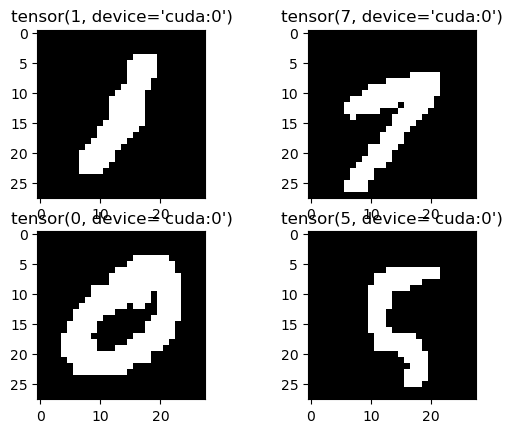

In [4]:
# Show 4 random images from the training dataset in grid
fig, ax = plt.subplots(2, 2)
for i in range(2):
    for j in range(2):
        idx = torch.randint(0, len(train_dataset), (1,)).item()
        image = train_dataset[idx][0].squeeze().cpu()
        ax[i, j].imshow(image, cmap="gray")
        ax[i, j].set_title(train_dataset[idx][1])
plt.show()


In [5]:
# Hebbian Learning
torch.manual_seed(42)
model_name = "mnist_hopfield_hebbian"
size = 1
for dim in INPUT_SHAPE:
    size *= dim
actv_fn = FastHopfieldActivation(prefer=-1)
model = HopfieldNet(size, actv_fn=actv_fn, bias=True, steps=5).to(device)
step = 0

In [6]:
LR = 10e-4
BATCH_SIZE=32 # 8000 * DATA_RATIO seems effective
epochs = 2000
criterion = nn.MSELoss()
optimiser = optim.AdamW(model.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimiser, mode='min', min_lr=3e-9, factor=0.75, patience=150, verbose=True)
energy, step = train_denoise(model, 
                             train_dataset, 
                             val_dataset, 
                             optimiser, 
                             scheduler, 
                             model_name, 
                             epochs, 
                             flatten=True, 
                             step=step, 
                             error=True, 
                             batch_size=BATCH_SIZE, 
                             minimise='loss', 
                             model_dir='models/weights',
                             device=device)

Epoch 00971: reducing learning rate of group 0 to 7.5000e-04.


RuntimeError: File models/weights//mnist_hopfield_hebbian.pth cannot be opened.

In [7]:
print(f"Final energy: {energy[-1]}")

Final energy: 0.10606645792722702


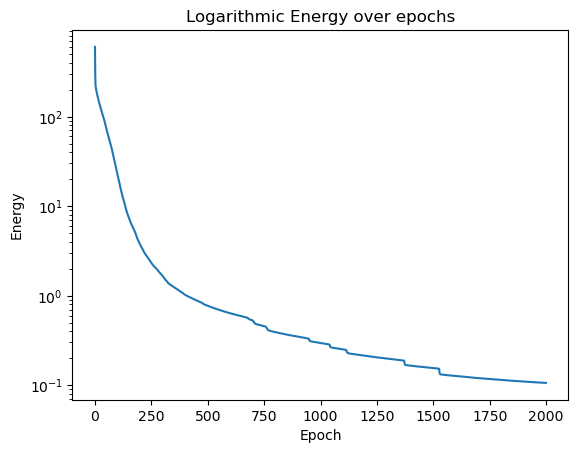

In [8]:
# plot energy over epochs
plt.plot(energy)
plt.yscale("log")
plt.title("Logarithmic Energy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Energy")
plt.show()


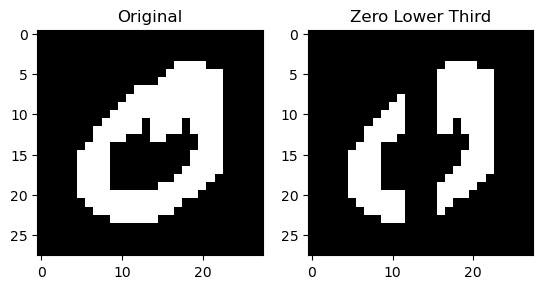

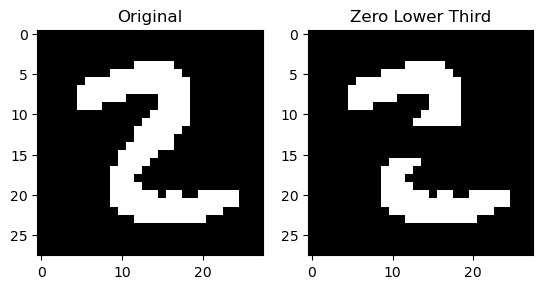

In [9]:
width=0.2
# Transform to zero lower third of image
def mask_center_column(image, width=width):
    image = image.clone()
    image[:, image.shape[1] // 2 - int(image.shape[1] * width) // 2 : image.shape[1] // 2 + int(image.shape[1] * width) // 2] = -1.0
    # image[2 * image.shape[0] // 3:, :] = -1.0
    return image

def mask_center_row(image, width=width):
    image = image.clone()
    image[image.shape[0] // 2 - int(image.shape[0] * width) // 2 : image.shape[0] // 2 + int(image.shape[0] * width) // 2, :] = -1.0
    return image

# Show original and masked image with subplots
fig, ax = plt.subplots(1, 2)
idx = torch.randint(0, len(train_dataset), (1,)).item()
image = train_dataset[idx][0].squeeze().cpu()
ax[0].imshow(image, cmap="gray")
ax[0].set_title("Original")
ax[1].imshow(mask_center_column(image), cmap="gray")
ax[1].set_title("Zero Lower Third")
plt.show()

# Show original and masked image with subplots
fig, ax = plt.subplots(1, 2)
idx = torch.randint(0, len(train_dataset), (1,)).item()
image = train_dataset[idx][0].squeeze().cpu()
ax[0].imshow(image, cmap="gray")
ax[0].set_title("Original")
ax[1].imshow(mask_center_row(image), cmap="gray")
ax[1].set_title("Zero Lower Third")
plt.show()

In [10]:
# Test model reconstruction with MAE Loss
model = model.to(device)
model.eval()
criterion = nn.L1Loss()
with torch.no_grad():
    total_loss = 0
    for i in range(len(train_dataset)):
        image = train_dataset[i][0].to(device)
        if torch.rand(1).item() > 0.5:
            masked_image = mask_center_column(image).to(device)
        else:
            masked_image = mask_center_row(image).to(device)
        output = model(masked_image.view(-1)).reshape(image.shape)
        loss = criterion(output, image)
        total_loss += loss.item()
    
    print(f"Average MAE Loss: {total_loss / len(train_dataset)}")

Average MAE Loss: 0.008583120734935315


c:\Users\Joe\anaconda3\envs\ml-env\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


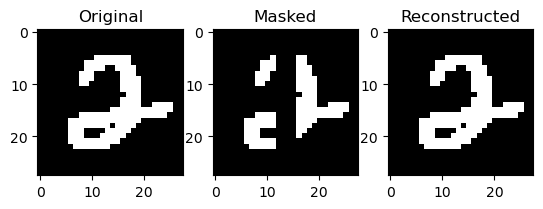

In [11]:
# Test if model can reconstruct masked image
model.to("cpu")
model.eval()

# Get random image from dataset
idx = torch.randint(0, len(train_dataset), (1,)).item()
image = train_dataset[idx][0].squeeze().cpu()
masked_image = mask_center_column(image)

# Convert to tensor and flatten
masked_image = torch.tensor(masked_image)
reconstructed_image = model(masked_image.view(-1), steps=40).view(INPUT_SHAPE)

# Plot original, masked and reconstructed image
fig, ax = plt.subplots(1, 3)
ax[0].imshow(image, cmap="gray")
ax[0].set_title("Original")
ax[1].imshow(masked_image, cmap="gray")
ax[1].set_title("Masked")
ax[2].imshow(reconstructed_image.detach().squeeze(0), cmap="gray")
ax[2].set_title("Reconstructed")
plt.show()

c:\Users\Joe\anaconda3\envs\ml-env\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


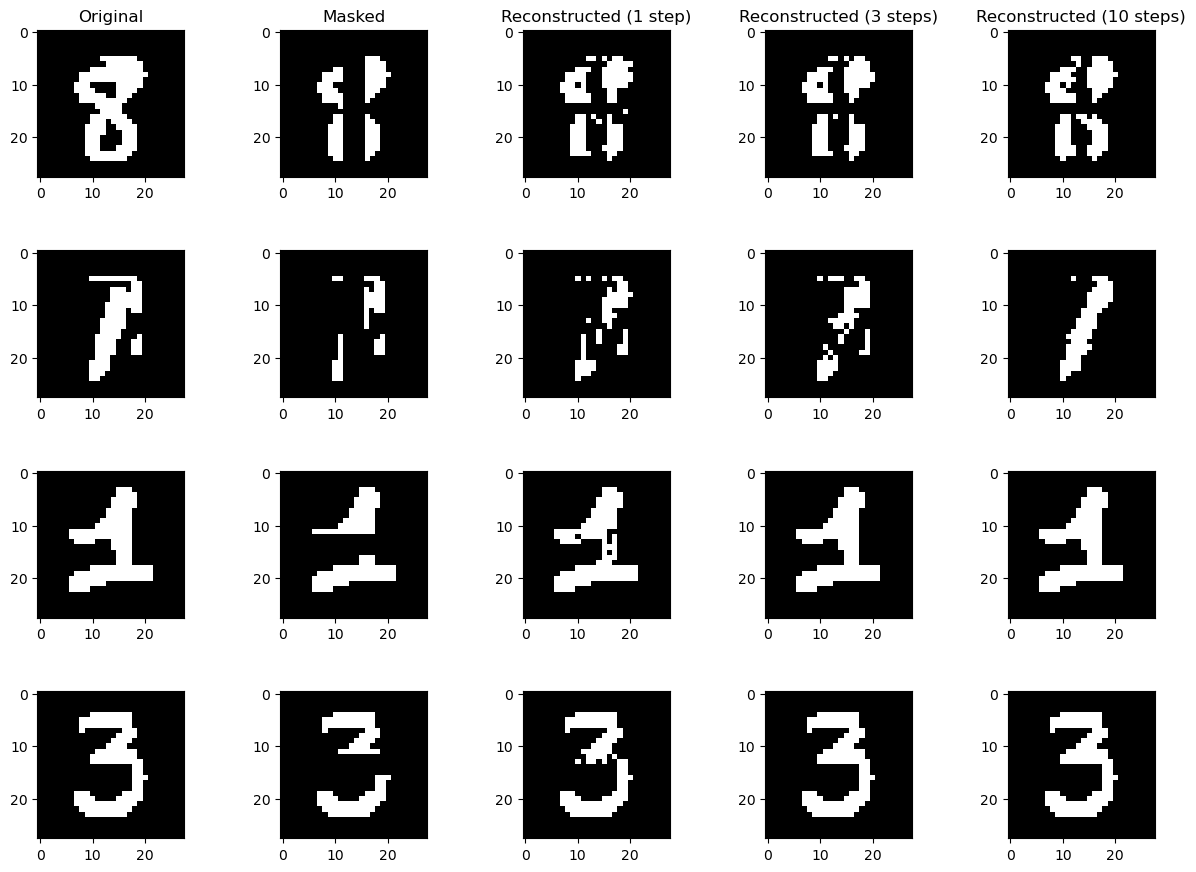

In [12]:
# Show 4 examples of original, masked and reconstructed images, with extra spacing between subplots
steps = (1, 3, 10)

# Randomly select 4 images from the training dataset
idxs = []
while len(idxs) < 4:
    idx = torch.randint(0, len(train_dataset), (1,)).item()
    if idx not in idxs:
        idxs.append(idx)

fig, ax = plt.subplots(4, 5)
for i in range(4):
    original = train_dataset[idxs[i]][0].squeeze().cpu()
    if i < 2:
        masked = mask_center_column(original)
    else:
        masked = mask_center_row(original)
    masked = torch.tensor(masked)
    reconstructed_1 = model(masked.view(-1), steps=steps[0]).view(INPUT_SHAPE)
    reconstructed_2 = model(masked.view(-1), steps=steps[1]).view(INPUT_SHAPE)
    reconstructed_3 = model(masked.view(-1), steps=steps[2]).view(INPUT_SHAPE)
    ax[i, 0].imshow(original, cmap="gray")
    ax[i, 1].imshow(masked, cmap="gray")
    ax[i, 2].imshow(reconstructed_1.detach().squeeze(0), cmap="gray")
    ax[i, 3].imshow(reconstructed_2.detach().squeeze(0), cmap="gray")
    ax[i, 4].imshow(reconstructed_3.detach().squeeze(0), cmap="gray")
    if i == 0:
        ax[i, 0].set_title("Original")
        ax[i, 1].set_title("Masked")
        ax[i, 2].set_title(f"Reconstructed ({steps[0]} step)")
        ax[i, 3].set_title(f"Reconstructed ({steps[1]} steps)")
        ax[i, 4].set_title(f"Reconstructed ({steps[2]} steps)")
    # Add extra spacing between subplots
    # Make images bigger
    fig.set_size_inches(15.5, 10.5)
    plt.subplots_adjust(wspace=0.05, hspace=0.5)


plt.show()

